# 車流量預測-以國道五號為例

目標: 加入事故資料並預測車輛和車流量提供用路人參考

因變數: 每天每小時車流量 

自變數: 
1. 常發生事故的時間 (下午14:00~17:00; 星期六和星期日) 
2. 根據歷史資料計算指定組別的平均、中位數和標準差，例如以平日假日、星期幾和小時去進算平均、中位數和標準差，並合併至資料集中當作因子。

資料區間: 2019/1/1~2019/12/31
1. 訓練集時間: 2019/1/1~2019/9/30
2. 測試集時間: 2019/10/1~2019/12/31

## I. 安裝套件和設定

In [1]:
library(dplyr, warn.conflicts = FALSE) # 資料處理
library(magrittr) # 更改欄位名稱 (set_colnames); %<>%
library(stringr) # 字串處理
library(lubridate, warn.conflicts = FALSE) # 時間處理
library(tidyr, warn.conflicts = FALSE) # 處理 NA (replace_na)
library(randomForest, warn.conflicts = FALSE) # 建立隨機森林模型
library(Metrics) # 計算RMSE (rmse)
RNGkind(sample.kind = "Rejection") # Random Number Generation的設定
library(ggplot2, warn.conflicts = FALSE) # 繪圖
options(scipen=999) # 數值不要以科學記號呈現

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.



## II. 讀入事故資料和車速車流量資料

1. 事件資料

包含事故發生的時間、事故級別、方向和回堵公里數。
2. 車速車流量資料

包含日期、小時、方向、時速、車流量和平日假日(0為平日; 1為星期五5點後和周末; 2為連續假期)。

In [2]:
data_accident = read.csv('short_messege_Accident.csv', stringsAsFactors = FALSE)
head(data_accident)
str(data_accident)

,級數,日期,時間,方向,回堵公里數
,<int>,<chr>,<chr>,<chr>,<dbl>
1,2,2019-01-03,03:42,北向,NA
2,3,2019-01-05,17:41,北向,2.0
3,2,2019-01-08,05:04,南向,NA
4,2,2019-01-08,08:41,北向,NA
5,3,2019-01-08,22:09,北向,NA
6,3,2019-01-09,17:12,北向,1.5


'data.frame':	432 obs. of  5 variables:
 $ 級數      : int  2 3 2 2 3 3 3 2 3 3 ...
 $ 日期      : chr  "2019-01-03" "2019-01-05" "2019-01-08" "2019-01-08" ...
 $ 時間      : chr  "03:42" "17:41" "05:04" "08:41" ...
 $ 方向      : chr  "北向" "北向" "南向" "北向" ...
 $ 回堵公里數: num  NA 2 NA NA NA 1.5 NA NA NA 0.5 ...


In [3]:
data_sp_vol = read.csv('VD_sp_vol.csv', stringsAsFactors = FALSE)
head(data_sp_vol)
str(data_sp_vol)

,Date,Weekday,Hour,Direction,Speed,Volume,Holiday_Label
,<chr>,<chr>,<int>,<chr>,<dbl>,<int>,<int>
1,2019/1/1,星期二,0,North,79.89083,1043,2
2,2019/1/1,星期二,0,South,85.38361,570,2
3,2019/1/1,星期二,1,North,80.38067,983,2
4,2019/1/1,星期二,1,South,84.30533,761,2
5,2019/1/1,星期二,2,North,81.95773,626,2
6,2019/1/1,星期二,2,South,84.78433,619,2


'data.frame':	17054 obs. of  7 variables:
 $ Date         : chr  "2019/1/1" "2019/1/1" "2019/1/1" "2019/1/1" ...
 $ Weekday      : chr  "星期二" "星期二" "星期二" "星期二" ...
 $ Hour         : int  0 0 1 1 2 2 3 3 4 4 ...
 $ Direction    : chr  "North" "South" "North" "South" ...
 $ Speed        : num  79.9 85.4 80.4 84.3 82 ...
 $ Volume       : int  1043 570 983 761 626 619 466 400 423 294 ...
 $ Holiday_Label: int  2 2 2 2 2 2 2 2 2 2 ...


## III. 資料清洗
1. 在事件資料中，處理時間 (Time)、方向 (Direction)中的字串，並增加星期幾 (Weekday)和小時 (Hour)兩欄位。
2. 在車速車流量資料中，將車速取四捨五入為整數，並日期 (Date)轉成日期型態以及平日假日 (Holiday_Label)轉成因子變數。

In [4]:
data_accident %<>% set_colnames( c('Level', 'Date', 'Time', 'Direction', 'KM') ) %>%
                   mutate( Time = str_replace( Time, ';', ':'  ), 
                           Direction = case_when( str_detect(Direction, '南')~'South',  str_detect( Direction, '北')~'North', TRUE~'Unsure' ),
                           Weekday = wday( Date, label =T, abbr = F ), 
                           Hour = suppressWarnings( as.numeric( str_sub(Time, 1, 2) ) ) ) %>%
                           select( -Direction )
head(data_accident)

,Level,Date,Time,KM,Weekday,Hour
,<int>,<chr>,<chr>,<dbl>,<ord>,<dbl>
1,2,2019-01-03,03:42,NA,星期四,3
2,3,2019-01-05,17:41,2.0,星期六,17
3,2,2019-01-08,05:04,NA,星期二,5
4,2,2019-01-08,08:41,NA,星期二,8
5,3,2019-01-08,22:09,NA,星期二,22
6,3,2019-01-09,17:12,1.5,星期三,17


In [5]:
data_sp_vol %<>% mutate( Speed = round(Speed), Date = as.Date(Date), Month = month(Date), 
                         Holiday_Label = as.factor(Holiday_Label) )
head(data_sp_vol)

,Date,Weekday,Hour,Direction,Speed,Volume,Holiday_Label,Month
,<date>,<chr>,<int>,<chr>,<dbl>,<int>,<fct>,<dbl>
1,2019-01-01,星期二,0,North,80,1043,2,1
2,2019-01-01,星期二,0,South,85,570,2,1
3,2019-01-01,星期二,1,North,80,983,2,1
4,2019-01-01,星期二,1,South,84,761,2,1
5,2019-01-01,星期二,2,North,82,626,2,1
6,2019-01-01,星期二,2,South,85,619,2,1


## IV. 特徵工程
探討並新增兩大類自變數

自變數: 
1. 常發生事故的時間 (下午14:00~17:00; 六日) 
2. 根據歷史資料計算指定組別的車流量平均、中位數和標準差，例如以平日假日、星期幾和小時去計算平均、中位數和標準差，並合併至資料集中當作因子。

## 1. 事故相關因子

(1) 根據每小時發生的事件數量來繪製 Density Plot

下午14:00~19:00為高事故時間，將增加下午 (14:00~19:00)因子進入模型中。

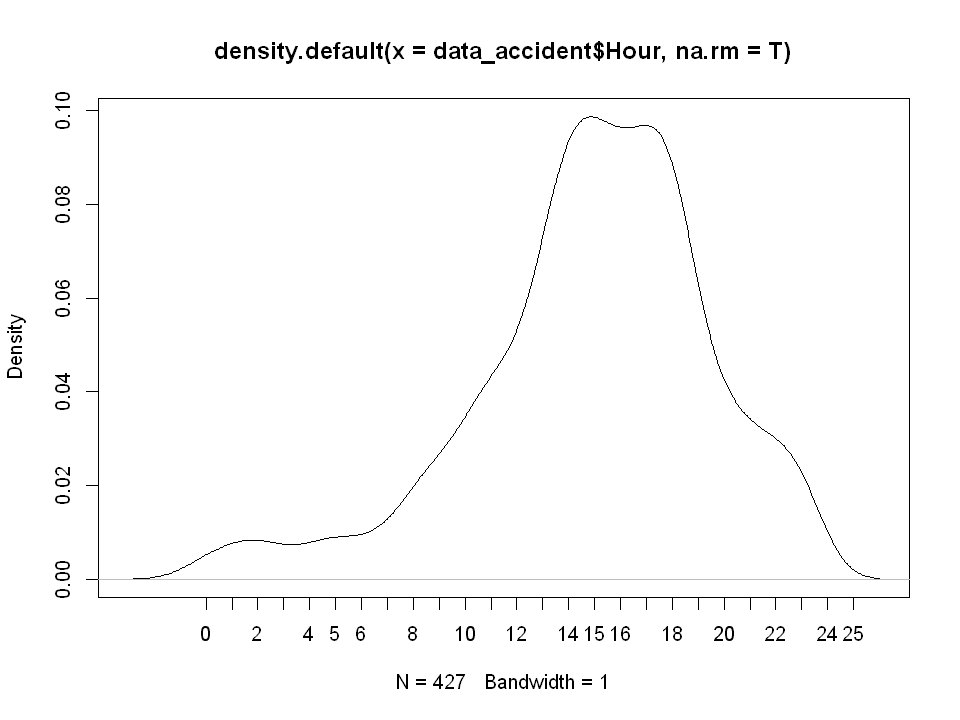

In [6]:
x = data_accident %>% filter( !is.na(Hour) ) %>% select(Hour)

options( repr.plot.width = 8, repr.plot.height = 6)
plot( density( data_accident$Hour,na.rm = T) )
axis( side=1, at=seq(0, 24, 1) ) 

(2) 每星期每天發生事件的總數

星期六和星期日的發生事件總數高於星期一到星期五，將增加假日(星期六和星期日)因子進入模型中。

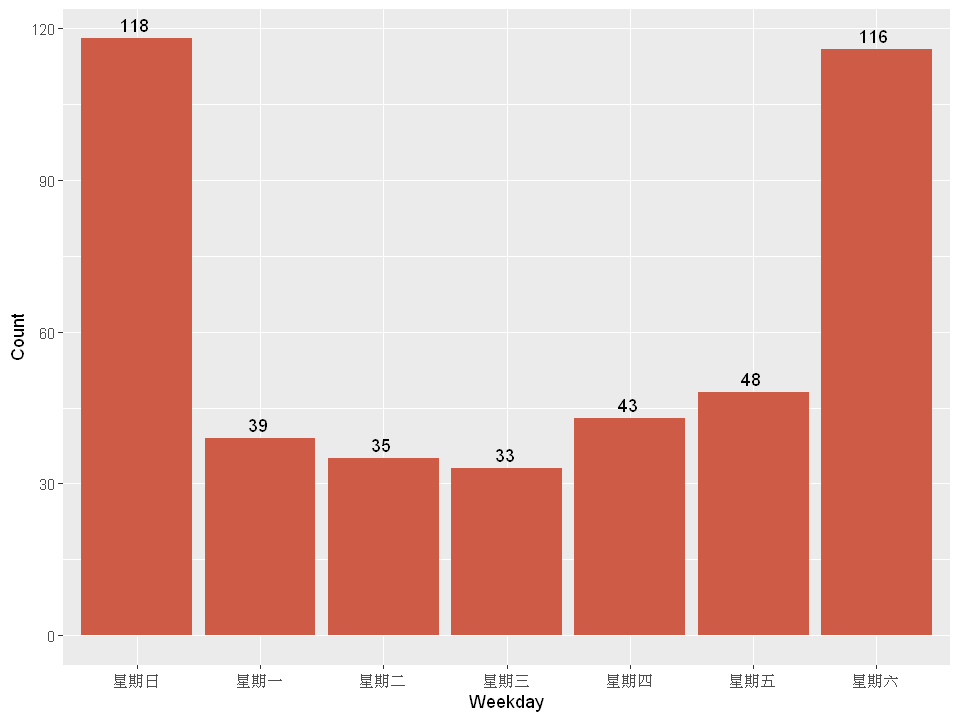

In [7]:
accident_w = data_accident %>% group_by(Weekday) %>% summarise( Count = n() )  

ggplot( accident_w, aes( x = Weekday, y = Count) ) + 
  geom_bar( stat = 'identity', fill = 'coral3' ) + 
  geom_text( aes( y = Count, label = Count ), hjust = 0.6, vjust = -0.5 )

* 增加兩個事故相關因子到模型中，分別是下午(14:00~19:00)和假日(星期六和星期日)。

In [8]:
data_sp_vol %<>% mutate( Acc_High_Day = ifelse( Weekday %in% c( '星期六', '星期日' ), 1 , 0 ) , 
                         Acc_High_Hour = ifelse( Hour >= 14 & Hour < 19 , 1 , 0 )  )
head(data_sp_vol)

,Date,Weekday,Hour,Direction,Speed,Volume,Holiday_Label,Month,Acc_High_Day,Acc_High_Hour
,<date>,<chr>,<int>,<chr>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>
1,2019-01-01,星期二,0,North,80,1043,2,1,0,0
2,2019-01-01,星期二,0,South,85,570,2,1,0,0
3,2019-01-01,星期二,1,North,80,983,2,1,0,0
4,2019-01-01,星期二,1,South,84,761,2,1,0,0
5,2019-01-01,星期二,2,North,82,626,2,1,0,0
6,2019-01-01,星期二,2,South,85,619,2,1,0,0


### 2. 車流量相關因子

In [9]:
data_Volume1 = data_sp_vol %>% group_by( Direction, Holiday_Label, Weekday, Hour) %>% 
                               summarise( mean1 = round( mean(Volume) ), median1 = round( median(Volume) ), sd1 = round( sd(Volume) ), .groups = 'drop' ) %>% 
                               mutate( sd1 = replace_na(sd1, 0)  )
data_Volume2 = data_sp_vol %>% group_by( Direction, Weekday) %>% 
                               summarise( mean2 = round( mean(Volume) ), median2 = round( median(Volume) ), sd2 = round( sd(Volume) ), .groups = 'drop' ) %>% 
                               mutate( sd2 = replace_na(sd2, 0)  )
data_Volume3 = data_sp_vol %>% group_by( Direction, Holiday_Label, Hour) %>% 
                               summarise( mean3 = round( mean(Volume) ), median3 = round( median(Volume) ), sd3 = round( sd(Volume) ), .groups = 'drop' ) %>% 
                               mutate( sd3 = replace_na(sd3, 0)  )

In [10]:
# 合併至車流量資料中
data_sp_vol %<>% left_join( data_Volume1, by = c('Direction', 'Holiday_Label', 'Weekday', 'Hour' ) ) %>%   
                 left_join( data_Volume2, by = c('Direction','Weekday' ) ) %>% 
                 left_join( data_Volume3, by = c('Direction', 'Holiday_Label', 'Hour' ) )

In [11]:
# 轉換Holiday_Label為dummy variables
data_label = as.data.frame( model.matrix( ~Holiday_Label, data = data_sp_vol) )
data_label = data.frame( model.matrix( ~Holiday_Label, data = data_sp_vol ) )
data_sp_vol = bind_cols( data_sp_vol, select(data_label, -1) ) %>% select(-Holiday_Label)
head(data_sp_vol)

,Date,Weekday,Hour,Direction,Speed,Volume,Month,Acc_High_Day,Acc_High_Hour,mean1,median1,sd1,mean2,median2,sd2,mean3,median3,sd3,Holiday_Label1,Holiday_Label2
,<date>,<chr>,<int>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2019-01-01,星期二,0,North,80,1043,1,0,0,905,905,195,1085,1180,682,1223,905,765,0,1
2,2019-01-01,星期二,0,South,85,570,1,0,0,898,898,463,1077,1186,687,924,568,611,0,1
3,2019-01-01,星期二,1,North,80,983,1,0,0,766,766,307,1085,1180,682,923,628,701,0,1
4,2019-01-01,星期二,1,South,84,761,1,0,0,979,979,308,1077,1186,687,761,444,645,0,1
5,2019-01-01,星期二,2,North,82,626,1,0,0,466,466,226,1085,1180,682,554,352,528,0,1
6,2019-01-01,星期二,2,South,85,619,1,0,0,758,758,197,1077,1186,687,516,349,438,0,1


## V. 建模與評估--隨機森林(Random Forest)

In [12]:
# 篩選方向的function
filter_data = function(dataset, direc){
  dataset %>% filter(Direction == direc)
}

set.seed(6666)
direction = 'South'
data1 = filter_data(data_sp_vol, direction) 

* 建立隨機森林 (Random Forest)模型

In [13]:
# 建立Training和Test dataset
data1_train = data1 %>% filter( Month %in% 1:9 ) 
data1_test = data1 %>% filter( Month %in% 10:12 ) 
# 建立隨機森林 (Random Forest)模型
xreg = select( data1_train, Volume, Acc_High_Day:Holiday_Label2 )  
model_rf = randomForest( Volume ~ ., data = xreg, importane = T, proximity = T, do.trace = 100)

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 100 | 8.278e+04    13.57 |
 200 | 8.241e+04    13.51 |
 300 | 8.238e+04    13.50 |
 400 | 8.232e+04    13.49 |
 500 | 8.228e+04    13.49 |


* 顯示訓練的每個tree的誤差

在第180顆tree時誤差率開始穩定。

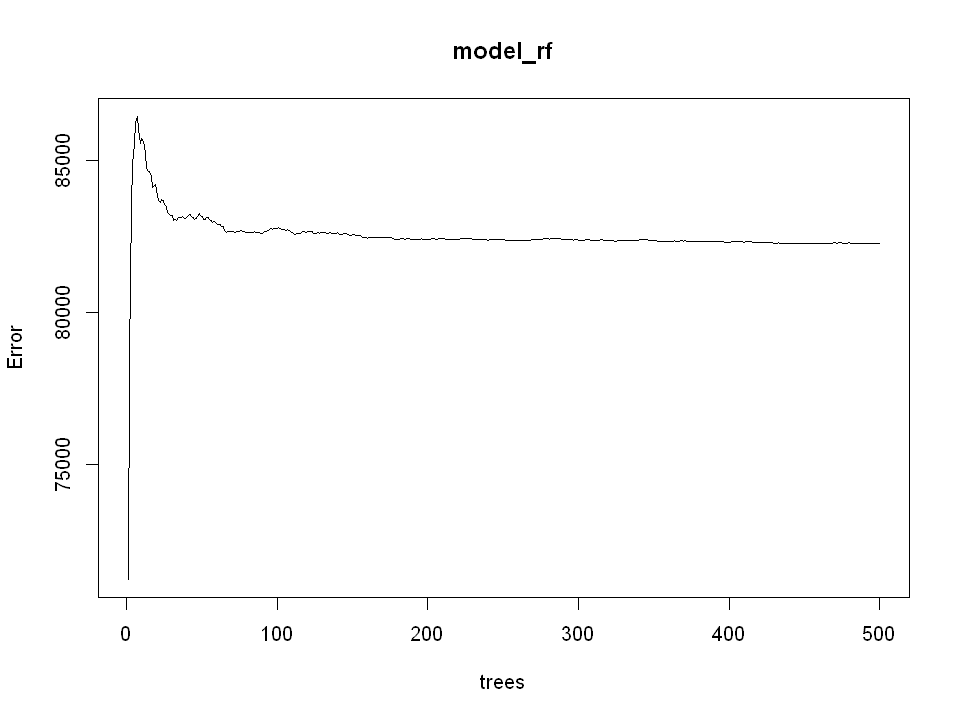

In [14]:
plot(model_rf)

* 畫出變數重要性圖形(由大至小排列)

車流量相關因子的重要性大於事故相關因子和平日假日(Holiday_Label*)。

車流量相關因子中，以平日假日、星期幾、小時計算的車流量平均數(mean1)和中位數(median1)的重要最高，其次是以平日假日、小時計算的車流量平均數(mean1)和中位數(median3)。

單純以星期幾計算的車流量平均數(mean2)、中位數(median2)和標準差(sd3)的重要性低。

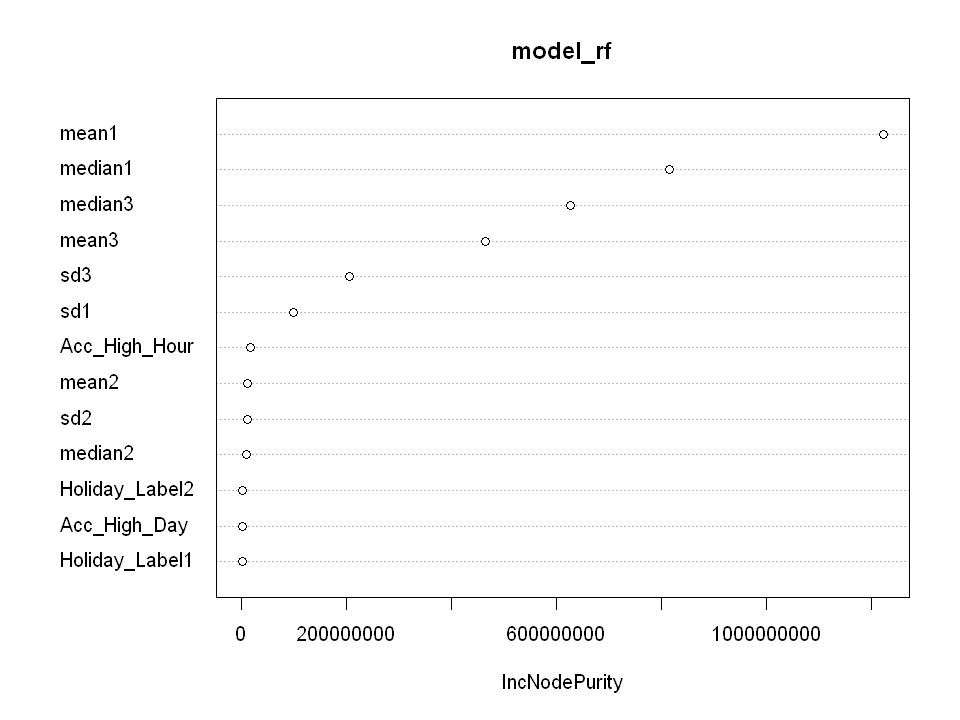

In [15]:
varImpPlot(model_rf, sort = TRUE)

* 預測測試集的車流量

In [16]:
xreg_pred = select( data1_test, Acc_High_Day:Holiday_Label2 ) 
prediction = predict(model_rf, newdata = xreg_pred)
# 建立比較的Data Frame
data1_comp = data1_test %>% bind_cols( Volume_pred = round( prediction ) )

* 列出預測值與真實質差異最多的日期和小時

10/9晚上和12/31晚上的車流量低估，連假前一天晚上的實際車流量較預測值高，可以將相關的變數加入來提高預測效果。

In [17]:
data1_comp2 = data1_comp %>% mutate( diff = abs(Volume_pred-Volume), pent = round( (Volume_pred- Volume)/Volume, 2 ) ) %>% 
                             select(Date, Weekday, Hour, Direction, Volume, Volume_pred, diff, pent ) %>% arrange(desc(diff)) %>%
                             mutate( rank = row_number() )
head(data1_comp2)

,Date,Weekday,Hour,Direction,Volume,Volume_pred,diff,pent,rank
,<date>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>
13232,2019-10-09,星期三,22,South,2554,838,1716,-0.67,1
13234,2019-10-09,星期三,23,South,2249,567,1682,-0.75,2
17052,2019-12-31,星期二,20,South,2477,1020,1457,-0.59,3
13230,2019-10-09,星期三,21,South,2379,949,1430,-0.60,4
17050,2019-12-31,星期二,19,South,2607,1313,1294,-0.50,5
16240,2019-12-14,星期六,14,South,1038,2295,1257,1.21,6


* 畫出車流量差異的Density Plot

50%項目的差異在71以下。

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0    28.0    71.0   114.5   148.0  1716.0 

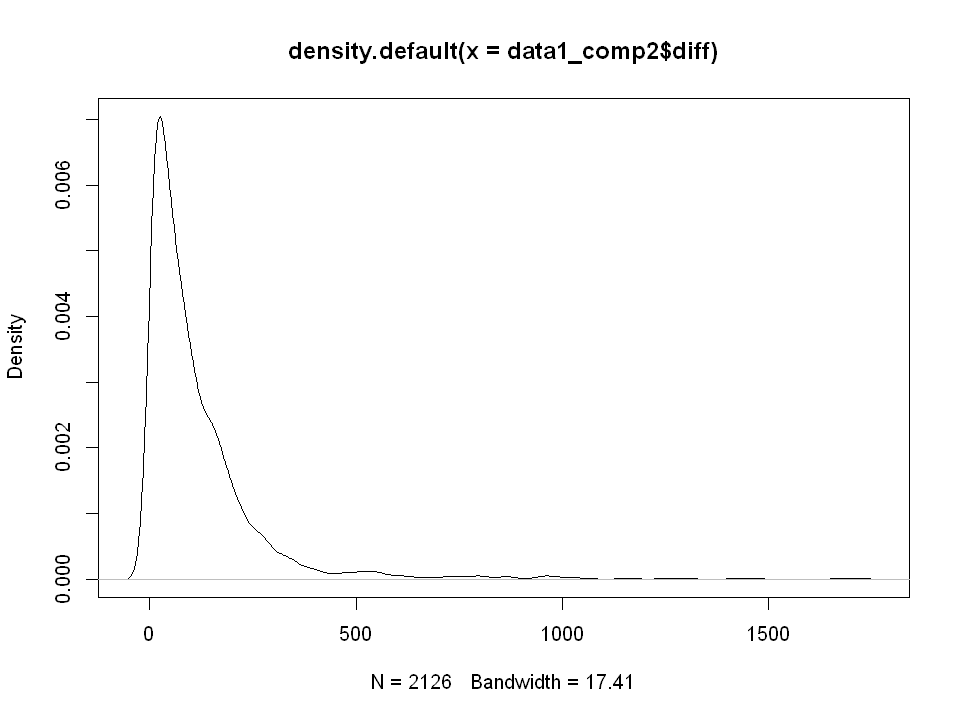

In [18]:
plot( density( data1_comp2$diff ) )
summary( data1_comp2$diff )

* 評估指標


1. RMSE約為190.5，最小越好，通常以不同模型來比較 (時間數列模型的RMSE為650)。
2. MAE約為114.5，最小越好，代表預測值與實際值的差異約為114.5。
3. MAPE約為13.3%，最接近0代表預測值與實際值的差異小，代表預測值與實際值的差異約為實際值的13%。

In [19]:
# RMSE
rmse( data1_comp$Volume_pred, data1_comp$Volume )
# MAE
mean( abs( data1_comp$Volume_pred - data1_comp$Volume ) )    
# MAPE
mean( abs( (data1_comp$Volume_pred - data1_comp$Volume) / data1_comp$Volume ) ) 

[1] 190.5368

[1] 114.4864

[1] 0.1327179

* 比較訓練集的預測值與實際值

除了特定日期之外，大致上實際車流量(黑線)接近預測車流量(紅線)。

在連假前一天預測的狀況不好，例如: 10/9和12/31。此外，特殊日期的車流量也低估，例如: 12/25。

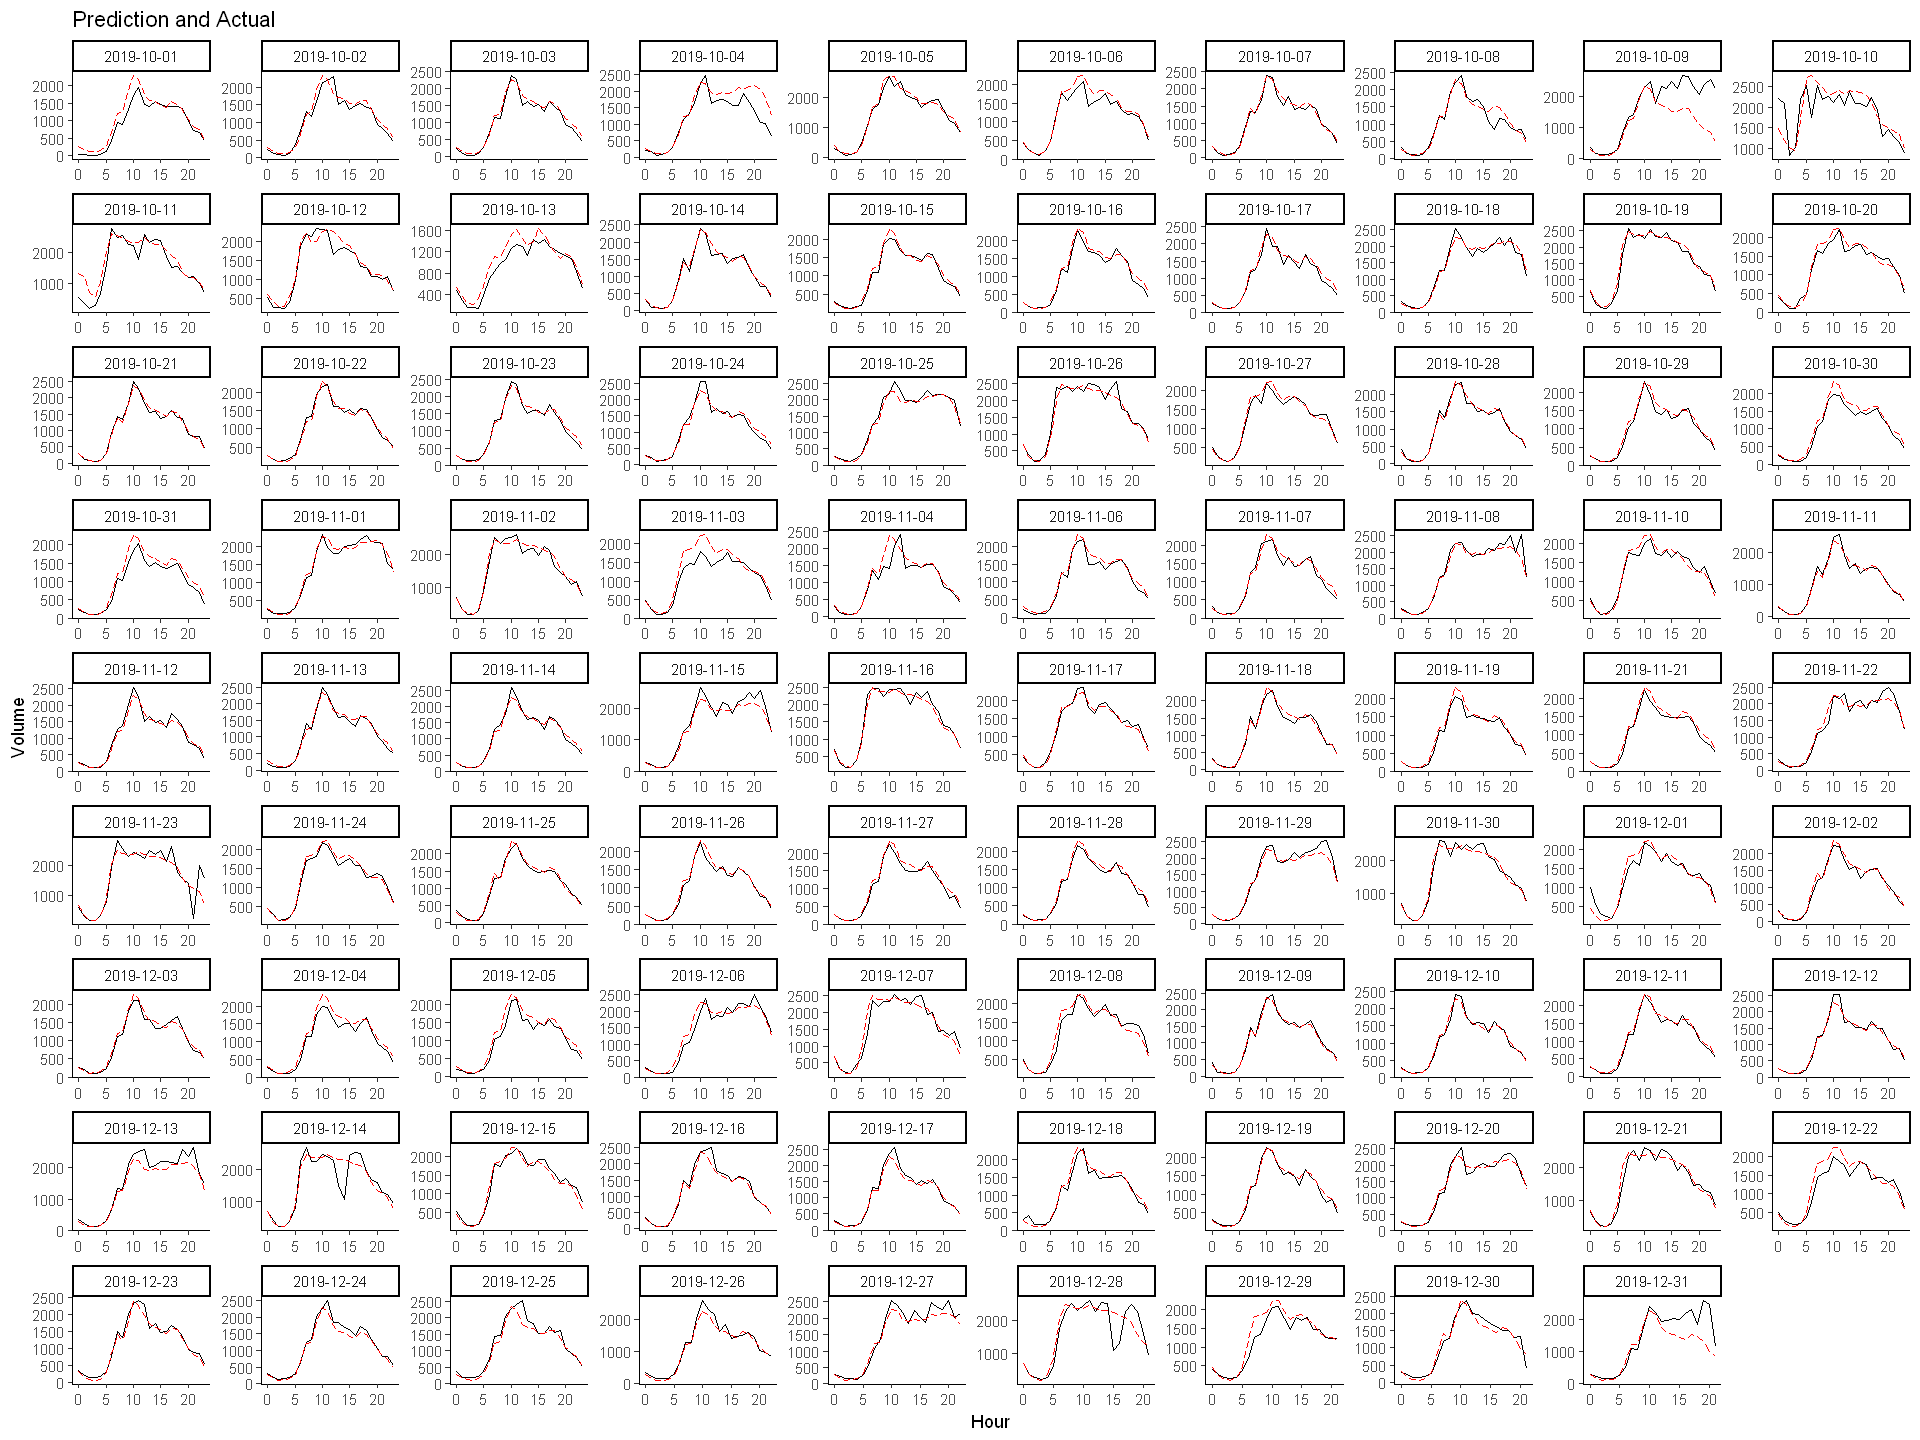

In [20]:
# 調整圖的寬度和高度
options(repr.plot.width=16, repr.plot.height=12)

ggplot( data = data1_comp, aes(x= Hour) ) + 
  geom_line( aes(y = Volume, group = 1),  color = 'black' ) + 
  geom_line( aes(y = Volume_pred, group = 1),  color = 'red', linetype = 'longdash' ) +
  facet_wrap(~Date, scales = "free") +
  ggtitle( 'Prediction and Actual' ) +
  theme(axis.title.x=element_blank(), axis.text.x = element_text(angle = 90 ) ) +
  theme_classic() 